# Set of points registration (face)

In [ ]:
from google.colab import drive
import torch as tc
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/My Drive/KU/MIA' 
os.chdir(root_path)

Mounted at /content/gdrive


[[0.30955021 0.34011685 0.32753325 0.32088789 0.35561439 0.31600523
  0.38267398 0.31863207 0.4053134  0.33613518 0.38273391 0.33630374
  0.35553586 0.33251351 0.32798553 0.33700201 0.55806112 0.35321224
  0.5399971  0.34457508 0.51284069 0.33799139 0.48301294 0.33821645
  0.45961291 0.33613366 0.48338646 0.32161343 0.51333833 0.32124051
  0.54010683 0.32857007 0.33666871 0.36769216 0.34908357 0.35667885
  0.36298043 0.35182691 0.37995542 0.36175941 0.39016052 0.37326565
  0.38006837 0.37603822 0.36391387 0.37900546 0.34907425 0.37687437
  0.52630758 0.37296924 0.51664449 0.37981739 0.50090826 0.38357382
  0.48445087 0.38002343 0.47358284 0.37836343 0.48433138 0.36337176
  0.50105773 0.35530622 0.51636276 0.36197387 0.36226282 0.3630378
  0.50192814 0.36845955 0.45142648 0.37642282 0.45395577 0.44838348
  0.47119912 0.48280437 0.46142793 0.50277844 0.44881198 0.48686001
  0.42724669 0.50375795 0.40854293 0.48621264 0.39552606 0.50197012
  0.38658546 0.48050333 0.40441254 0.44745088 0.4

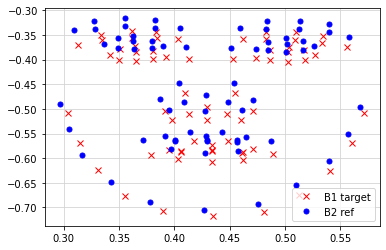

In [ ]:
# Create a list where each element is a vector of floats (a row of the txt file)

def open_shape(filename):
  with open(f"Data4/{filename}") as f:
    array = []
    cnt=0;
    for line in f: # read  lines
        array.append([float(x) for x in line.split()])
  return array

# Preprocess the data (we want each row to be the points of each axis)
brain_1 = open_shape("shape1.txt")
brain_2 = open_shape("shape2.txt")
brain_1 = np.transpose(np.array(brain_1))
brain_2 = np.transpose(np.array(brain_2))

print(brain_2)
print(len(brain_1[0,::2]))
print(len(brain_1[0,1::2]))
brain_1 = np.concatenate((brain_1[0,::2], -brain_1[0,1::2]))
brain_2 = np.concatenate((brain_2[0,::2], -brain_2[0,1::2]))
print("shape_b1", brain_1.shape)
print("shape_b2", brain_2.shape)

# Add vector of ones
one = np.ones(73)
B1 = tc.from_numpy(np.concatenate((brain_1, one)).reshape([3, 73]))
B2 = tc.from_numpy(np.concatenate((brain_2, one)).reshape([3, 73]))

def plot_transform(B_1, B_2, B_3=None, title=None):
  plt.plot(B_1[0,:],B_1[1,:], "rx", zorder=2, label = "B1 target")
  plt.plot(B_2[0,:],B_2[1,:], "bo", zorder=2, markersize = 5, label = "B2 ref")
  if B_3 != None:
    plt.plot(B_3[0,:].detach().numpy(), B_3[1,:].detach().numpy(), "go", 
             zorder=2, markersize = 5, label = "B3 transf")
  plt.grid(zorder=0, color="lightgray")
  plt.legend()
  if title != None:
    plt.title(title)
  plt.show()

plot_transform(B1, B2)              

# Rigid transformation registration


In [ ]:
# Rigid transformation functions

def rigid(par):
  t, x, y = par
  return tc.stack([tc.cat([tc.cos(t), -tc.sin(t), x]),
                   tc.cat([tc.sin(t), tc.cos(t), y]),
                   tc.tensor([0.0,0.0,1.0])])

def rigid_registration(b1, b2, iterations, l_rate, adam=False):
  # Inizialization
  t = tc.tensor([0.0], requires_grad=True)      
  x = tc.tensor([0.0], requires_grad=True)
  y = tc.tensor([0.0], requires_grad=True)
  loss_list = []
  # Optimization
  if adam:
    optimizer=optim.Adam([t,x,y],l_rate)  
  for i in range(iterations):
    # Apply transformation and compute the gradient of the loss
    R = rigid((t, x, y))
    loss=tc.sum((B2.float()-tc.mm(R,B1.float()))**2)
    loss.backward() 
    loss_list.append(loss)
    print(f'Loss {loss:.4}')
    # Update paramer
    if adam:
      optimizer.step()
      optimizer.zero_grad()
    else:
      t.data.sub_(t.grad.data*l_rate) 
      x.data.sub_(x.grad.data*l_rate) 
      y.data.sub_(y.grad.data*l_rate) 
      t.grad.data.zero_() 
      x.grad.data.zero_() 
      y.grad.data.zero_() 
  return (t,x,y), loss_list

Loss 0.03668
Loss 0.02627
Loss 0.01908
Loss 0.01409
Loss 0.0106
Loss 0.008159
Loss 0.00644
Loss 0.005224
Loss 0.004362
Loss 0.003748
Loss 0.003309
Loss 0.002994
Loss 0.002768
Loss 0.002604
Loss 0.002486
Loss 0.002399
Loss 0.002336
Loss 0.00229
Loss 0.002255
Loss 0.002229
Loss 0.00221
Loss 0.002195
Loss 0.002183
Loss 0.002174
Loss 0.002166
Loss 0.00216
Loss 0.002154
Loss 0.00215
Loss 0.002145
Loss 0.002141
Loss 0.002138
Loss 0.002134
Loss 0.002131
Loss 0.002128
Loss 0.002125
Loss 0.002122
Loss 0.002119
Loss 0.002116
Loss 0.002113
Loss 0.00211
Loss 0.002107
Loss 0.002104
Loss 0.002102
Loss 0.002099
Loss 0.002096
Loss 0.002093
Loss 0.00209
Loss 0.002088
Loss 0.002085
Loss 0.002082
Loss 0.002079
Loss 0.002077
Loss 0.002074
Loss 0.002071
Loss 0.002068
Loss 0.002066
Loss 0.002063
Loss 0.00206
Loss 0.002058
Loss 0.002055
Loss 0.002052
Loss 0.00205
Loss 0.002047
Loss 0.002045
Loss 0.002042
Loss 0.002039
Loss 0.002037
Loss 0.002034
Loss 0.002032
Loss 0.002029
Loss 0.002026
Loss 0.002024
Loss 0.

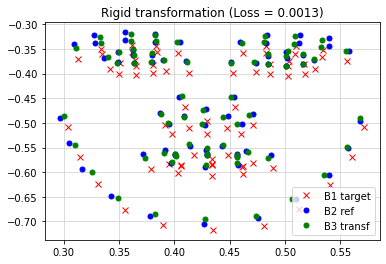

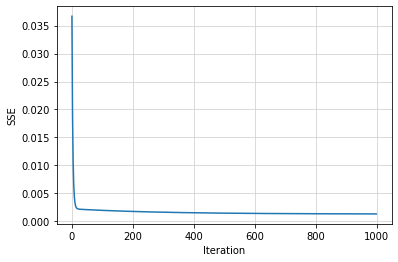

t = tensor([-0.0172], requires_grad=True)
x = tensor([0.0051], requires_grad=True)
y = tensor([0.0290], requires_grad=True)


In [ ]:
## Rigid 1 ##

# Obtain optimal parameters
l_rate = 0.001                                                      
iterations = 1000
adam = False
par, loss_rigid = rigid_registration(B1, B2, 
                                     iterations=iterations, 
                                     l_rate=l_rate,
                                     adam=adam)
# Apply transformation
R = rigid(par) 
B3 = tc.mm(R,B1.float())
plot_transform(B1, B2, B3, title=f"Rigid transformation (Loss = {loss_rigid[len(loss_rigid)-1]:.2})")

# Plot
plt.plot(loss_rigid)
plt.ylabel("SSE")
plt.xlabel("Iteration")
plt.grid(zorder=0, color="lightgray")
plt.show()

print("t =", par[0])
print("x =", par[1])
print("y =", par[2])

Loss 0.03668
Loss 0.02795
Loss 0.02063
Loss 0.01472
Loss 0.01013
Loss 0.006771
Loss 0.004533
Loss 0.003316
Loss 0.002978
Loss 0.003305
Loss 0.004028
Loss 0.004884
Loss 0.00567
Loss 0.006257
Loss 0.006581
Loss 0.006621
Loss 0.00639
Loss 0.005941
Loss 0.005349
Loss 0.004705
Loss 0.004087
Loss 0.003556
Loss 0.003147
Loss 0.002873
Loss 0.002733
Loss 0.002712
Loss 0.002784
Loss 0.002914
Loss 0.00306
Loss 0.003186
Loss 0.003264
Loss 0.003284
Loss 0.003247
Loss 0.003161
Loss 0.003037
Loss 0.002893
Loss 0.002746
Loss 0.002615
Loss 0.002512
Loss 0.002443
Loss 0.002407
Loss 0.002397
Loss 0.002405
Loss 0.002423
Loss 0.002441
Loss 0.002451
Loss 0.002447
Loss 0.002426
Loss 0.002392
Loss 0.002349
Loss 0.002302
Loss 0.002254
Loss 0.002211
Loss 0.002176
Loss 0.00215
Loss 0.002132
Loss 0.002121
Loss 0.002113
Loss 0.002105
Loss 0.002097
Loss 0.002085
Loss 0.002069
Loss 0.002049
Loss 0.002026
Loss 0.002003
Loss 0.00198
Loss 0.001959
Loss 0.00194
Loss 0.001924
Loss 0.00191
Loss 0.001898
Loss 0.001887
Loss

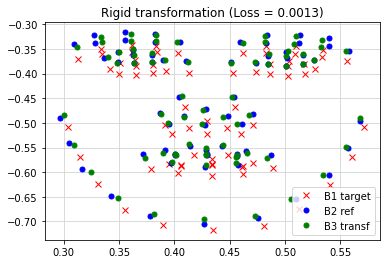

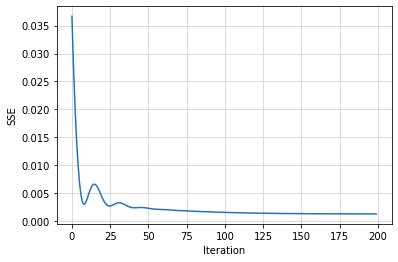

t = tensor([-0.0198], requires_grad=True)
x = tensor([0.0065], requires_grad=True)
y = tensor([0.0301], requires_grad=True)


In [ ]:
## Rigid 2 Adam ##

# Obtain optimal parameters
l_rate = 0.002                                                      
iterations = 200
adam=True
par, loss_rigid = rigid_registration(B1, B2,
                                     iterations=iterations, 
                                     l_rate=l_rate,
                                     adam=adam)
# Apply transformation
R = rigid(par) 
B3_rigid = tc.mm(R,B1.float())
plot_transform(B1, B2, B3_rigid, title=f"Rigid transformation (Loss = {loss_rigid[len(loss_rigid)-1]:.2})")

# Plot
plt.plot(loss_rigid)
plt.grid(zorder=0, color="lightgray")
plt.ylabel("SSE")
plt.xlabel("Iteration")
plt.show()

print("t =", par[0])
print("x =", par[1])
print("y =", par[2])

# Affine transformation registration

In [ ]:
# Affine transformation functions

def affine_registration(b1, b2, iterations, l_rate, adam=False):
  # Inizialization
  P = tc.zeros([3,3],requires_grad=True)                             
  P = P.float()
  I = tc.tensor([[1.0, 0.0, 0.0] ,[0.0,1.0,0.0], [0.0,0.0,1.0]])    
  loss_list = []
  # Optimization
  if adam:
    optimizer=optim.Adam([P],l_rate)  
  for i in range(iterations):
    # Apply transformation and compute the gradient of the loss
    R = I+P
    loss = tc.sum((B2.float()-tc.mm(R,B1.float()))**2)
    loss.backward() 
    loss_list.append(loss)
    print(f'Loss {loss:.2}')
    # Update paramer
    if adam:
      optimizer.step()
      optimizer.zero_grad()
    else:
      P.data.sub_(P.grad.data*l_rate) 
      P.grad.data.zero_() 
  return R, loss_list

Loss 0.037
Loss 0.0021
Loss 0.0021
Loss 0.0021
Loss 0.0021
Loss 0.002
Loss 0.002
Loss 0.002
Loss 0.002
Loss 0.002
Loss 0.002
Loss 0.002
Loss 0.002
Loss 0.002
Loss 0.002
Loss 0.0019
Loss 0.0019
Loss 0.0019
Loss 0.0019
Loss 0.0019
Loss 0.0019
Loss 0.0019
Loss 0.0019
Loss 0.0019
Loss 0.0019
Loss 0.0019
Loss 0.0019
Loss 0.0018
Loss 0.0018
Loss 0.0018
Loss 0.0018
Loss 0.0018
Loss 0.0018
Loss 0.0018
Loss 0.0018
Loss 0.0018
Loss 0.0018
Loss 0.0018
Loss 0.0018
Loss 0.0018
Loss 0.0018
Loss 0.0017
Loss 0.0017
Loss 0.0017
Loss 0.0017
Loss 0.0017
Loss 0.0017
Loss 0.0017
Loss 0.0017
Loss 0.0017
Loss 0.0017
Loss 0.0017
Loss 0.0017
Loss 0.0017
Loss 0.0017
Loss 0.0017
Loss 0.0017
Loss 0.0016
Loss 0.0016
Loss 0.0016
Loss 0.0016
Loss 0.0016
Loss 0.0016
Loss 0.0016
Loss 0.0016
Loss 0.0016
Loss 0.0016
Loss 0.0016
Loss 0.0016
Loss 0.0016
Loss 0.0016
Loss 0.0016
Loss 0.0016
Loss 0.0016
Loss 0.0016
Loss 0.0016
Loss 0.0016
Loss 0.0015
Loss 0.0015
Loss 0.0015
Loss 0.0015
Loss 0.0015
Loss 0.0015
Loss 0.0015
Los

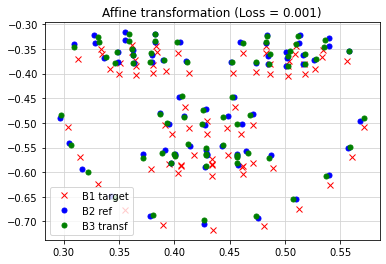

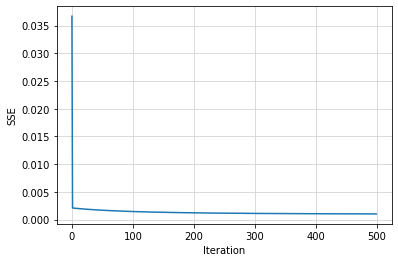

Updated R:
 tensor([[ 1.0228,  0.0206, -0.0031],
        [-0.0178,  1.0027,  0.0306],
        [ 0.0000,  0.0000,  1.0000]], grad_fn=<AddBackward0>)


In [ ]:
## Affine 1 ##

# Obtain optimal parameters
l_rate = 0.005                                                         
iterations = 500
adam = False
R, loss_affine = affine_registration(B1, B2,
                                       iterations=iterations, 
                                       l_rate=l_rate,
                                       adam=adam)
# Apply transformation
B3 = tc.mm(R,B1.float())
plot_transform(B1, B2, B3, title=f"Affine transformation (Loss = {loss_affine[len(loss_affine)-1]:.2})")

# Plot
plt.plot(loss_affine)
plt.ylabel("SSE")
plt.xlabel("Iteration")
plt.grid(zorder=0, color="lightgray")
plt.show()

print("Updated R:\n", R)

Loss 0.037
Loss 0.016
Loss 0.0035
Loss 0.0042
Loss 0.011
Loss 0.014
Loss 0.012
Loss 0.0089
Loss 0.0058
Loss 0.0034
Loss 0.0024
Loss 0.0032
Loss 0.005
Loss 0.0064
Loss 0.0063
Loss 0.0051
Loss 0.0037
Loss 0.0026
Loss 0.0022
Loss 0.0022
Loss 0.0026
Loss 0.0032
Loss 0.0036
Loss 0.0035
Loss 0.0028
Loss 0.0022
Loss 0.0018
Loss 0.0018
Loss 0.002
Loss 0.0022
Loss 0.0024
Loss 0.0024
Loss 0.0022
Loss 0.0019
Loss 0.0016
Loss 0.0016
Loss 0.0017
Loss 0.0018
Loss 0.0019
Loss 0.0018
Loss 0.0018
Loss 0.0016
Loss 0.0015
Loss 0.0015
Loss 0.0016
Loss 0.0016
Loss 0.0016
Loss 0.0016
Loss 0.0015
Loss 0.0015
Loss 0.0014
Loss 0.0014
Loss 0.0015
Loss 0.0015
Loss 0.0015
Loss 0.0014
Loss 0.0014
Loss 0.0014
Loss 0.0014
Loss 0.0014
Loss 0.0014
Loss 0.0014
Loss 0.0014
Loss 0.0014
Loss 0.0013
Loss 0.0013
Loss 0.0013
Loss 0.0013
Loss 0.0013
Loss 0.0013
Loss 0.0013
Loss 0.0013
Loss 0.0013
Loss 0.0013
Loss 0.0013
Loss 0.0013
Loss 0.0013
Loss 0.0013
Loss 0.0013
Loss 0.0013
Loss 0.0013
Loss 0.0013
Loss 0.0012
Loss 0.0012

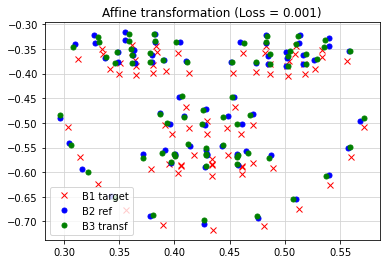

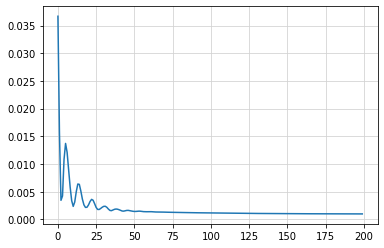

Updated R:
 tensor([[ 1.0296,  0.0205, -0.0062],
        [-0.0203,  1.0025,  0.0316],
        [ 0.0000,  0.0000,  1.0000]], grad_fn=<AddBackward0>)


In [ ]:
## Affine 2 Adam ##

# Obtain optimal parameters
l_rate = 0.005                                                      
iterations = 200
adam = True
R, loss_affine = affine_registration(B1, B2,
                                    iterations=iterations, 
                                    l_rate=l_rate,
                                    adam=adam)
# Apply transformation
B3_affine = tc.mm(R,B1.float())
plot_transform(B1, B2, B3_affine, title=f"Affine transformation (Loss = {loss_affine[len(loss_affine)-1]:.2})")

# Plot
plt.plot(loss_affine)
plt.grid(zorder=0, color="lightgray")
plt.show()

print("Updated R:\n", R)

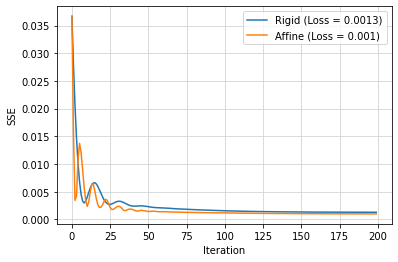

In [ ]:
# Final plots loss
plt.plot(loss_rigid, label = f"Rigid (Loss = {loss_rigid[len(loss_rigid)-1]:.2})")
plt.plot(loss_affine, label = f"Affine (Loss = {loss_affine[len(loss_affine)-1]:.2})")
plt.grid(zorder=0, color="lightgray")
plt.ylabel("SSE")
plt.xlabel("Iteration")
plt.legend()
plt.show()

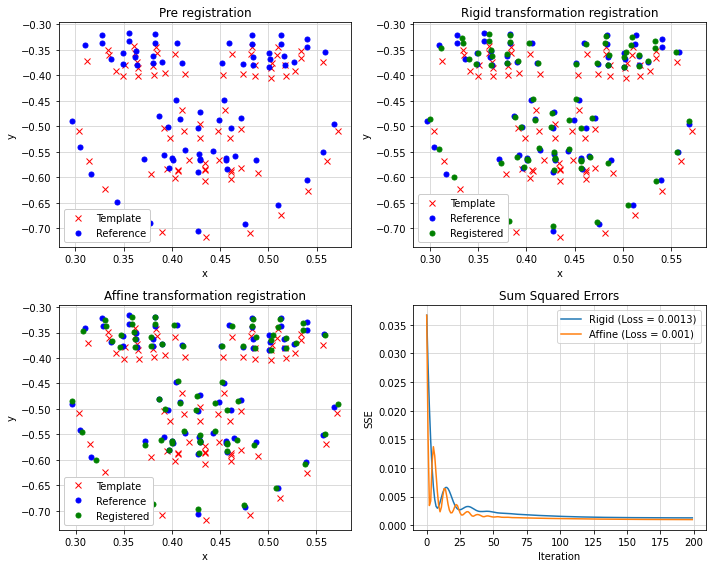

In [ ]:
# Final plot all in one

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,8))
ax1.plot(B1[0,:],B1[1,:], "rx", zorder=2, label = "Template")
ax1.plot(B2[0,:],B2[1,:], "bo", zorder=2, markersize = 5, label = "Reference")
ax1.set_title('Pre registration')
ax1.grid(zorder=0, color="lightgray")
ax1.set_ylabel("y")
ax1.set_xlabel("x")
ax1.legend(loc='lower left', framealpha=1)

ax2.plot(B1[0,:],B1[1,:], "rx", zorder=2, label = "Template")
ax2.plot(B2[0,:],B2[1,:], "bo", zorder=2, markersize = 5, label = "Reference")
ax2.plot(B3_rigid[0,:].detach().numpy(), B3_rigid[1,:].detach().numpy(), "go", 
         zorder=2, markersize = 5, label = "Registered")
ax2.set_title('Rigid transformation registration')
ax2.grid(zorder=0, color="lightgray")
ax2.set_ylabel("y")
ax2.set_xlabel("x")
ax2.legend(loc='lower left', framealpha=1)

ax3.plot(B1[0,:],B1[1,:], "rx", zorder=2, label = "Template")
ax3.plot(B2[0,:],B2[1,:], "bo", zorder=2, markersize = 5, label = "Reference")
ax3.plot(B3_affine[0,:].detach().numpy(), B3_affine[1,:].detach().numpy(), "go", 
         zorder=2, markersize = 5, label = "Registered")
ax3.set_title('Affine transformation registration')
ax3.grid(zorder=0, color="lightgray")
ax3.set_ylabel("y")
ax3.set_xlabel("x")
ax3.legend(loc='lower left', framealpha=1)

ax4.plot(loss_rigid, zorder=2, label = f"Rigid (Loss = {loss_rigid[len(loss_rigid)-1]:.2})")
ax4.plot(loss_affine, zorder=2, label = f"Affine (Loss = {loss_affine[len(loss_affine)-1]:.2})")
ax4.set_title('Sum Squared Errors')
ax4.grid(zorder=0, color="lightgray")
ax4.set_ylabel("SSE")
ax4.set_xlabel("Iteration")
ax4.legend()

fig.tight_layout()
plt.savefig(f"./Week7/plots_handin4/faces_registration.png", dpi=300)
plt.show()